# Does a vector autogregressive model fit have better behaviour relative to real climate forecasts?

In [1]:
import xarray as xr

import pandas as pd

from src import utils

import matplotlib.pyplot as plt

In [9]:
plt.rcParams["figure.figsize"] = (14, 6)
plt.rcParams["font.size"] = 12

In [3]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

In [4]:
DATA_DIR = "../../data/processed"

## Let's just fit to observations for now, though a fit to historical model runs may be more appropriate

In [5]:
HadISST = xr.open_zarr(f"{DATA_DIR}/tos_HadISST.zarr", use_cftime=True)
AMV = (
    utils.calculate_period_AMV_index(
        HadISST["sst"],
        [12, 1, 2, 3],
    )
    .rename("AMV")
    .compute()
)
AMV = utils.round_to_start_of_month(AMV, dim="time")
AMV = utils.get_observation_rolling_mean(AMV, [1, 4, 8])

In [6]:
HadSLP = xr.open_zarr(f"{DATA_DIR}/psl_HadSLP2r.zarr", use_cftime=True)
NAO = (
    utils.calculate_period_NAO_index(
        HadSLP["slp"],
        [12, 1, 2, 3],
    )
    .rename("NAO")
    .compute()
)
NAO = utils.get_observation_rolling_mean(NAO, [1, 4, 8])

In [7]:
AMV, NAO = xr.align(AMV, NAO)

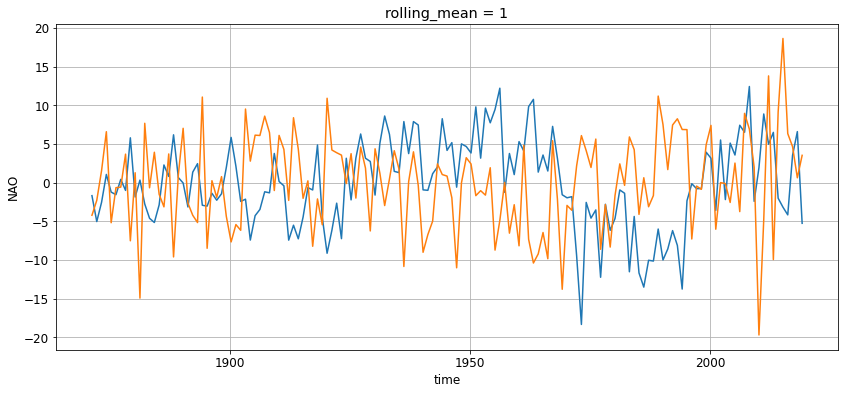

In [10]:
(40 * AMV).sel(rolling_mean=1).plot(label="AMV")
NAO.sel(rolling_mean=1).plot(label="NAO")

plt.grid()

## Fit a VAR model

In [9]:
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller

In [10]:
AMV_norm = (AMV).sel(rolling_mean=1, drop=True)
NAO_norm = (NAO).sel(rolling_mean=1, drop=True)

input_data = pd.concat(
    (
        AMV_norm.to_dataframe(),
        NAO_norm.to_dataframe(),
    ),
    axis=1,
)

Check that input series are stationary

In [11]:
signif = 0.05

for var in input_data.columns:
    res = adfuller(input_data[var])
    if res[1] < signif:
        print(f"{var} is stationary")
    else:
        print(f"{var} is non-stationary")

AMV is stationary
NAO is stationary


Fit the model

In [12]:
order = 2

model = VAR(input_data)
res = model.fit(order, trend="n")
res.summary()

/g/data/xv83/users/ds0092/software/miniconda3/envs/squire_2022_correlation/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 28, Jun, 2022
Time:                     10:01:24
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                  -0.635102
Nobs:                     147.000    HQIC:                 -0.731721
Log likelihood:          -350.526    FPE:                   0.450310
AIC:                    -0.797846    Det(Omega_mle):        0.426768
--------------------------------------------------------------------
Results for equation AMV
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
L1.AMV         0.435933         0.083004            5.252           0.000
L1.NAO        -0.000936         0.001562           -0.599           0.549
L2.AMV         0.258294         0.083413            3.097           0.002
L2.NAO         0

Simulate the process from a random inital condition

In [13]:
import numpy as np

from numpy.lib.stride_tricks import sliding_window_view


def predict(params, scale, inits, n_steps, n_members=1):
    """
    Advance a Vector Autoregressive model forward in time from initial conditions
    by n_steps

    Parameters
    ----------
    params : numpy array
        Array of shape [n_vars*M_lags, n_vars] containing the VAR(n) model
        coefficients as output by
        statsmodels.tsa.api.VAR(data).fit(n_lags, trend="n").params. That is, the
        coefficients along axis 0 should be ordered as
        [ϕ_var1_lag1, ..., ϕ_varN_lag1, ..., ϕ_var1_lagM, ..., ϕ_varN_lagM]
    scale : numpy array
        1D array of length n_vars containing the standard deviation of the noise
        terms in the VAR(n) model as output by
        statsmodels.tsa.api.VAR(data).fit(order, trend="n").resid.std()
    inits : numpy array
        Array containing the initial conditions. Can be 2D or 3D. If 2D, should
        be shape [n_inits, n_vars]. If 3D, should be shape [n_inits, n_samples,
        n_vars], where the final axis contains different samples of initial
        conditions
    n_steps : int
        The number of timesteps to step forward from each initial condition
    """

    def _epsilon(scale, size):
        return np.random.normal(scale=scale, size=size)

    n_params = params.shape[0]
    n_vars = params.shape[1]
    n_lags = int(n_params / n_vars)

    # Some quick checks
    assert len(inits) >= n_lags, (
        f"At least {order} initial conditions must be provided for an "
        f"AR({order}) model"
    )

    # Reorder the params so that they can be easily matmul by the predictors and
    # then appended to predictors to make the next prediction. I.e. reorder from
    # the input order:
    # var1_lag1, ..., varN_lag1, ..., var1_lagM, ..., varN_lagM
    # to:
    # var1_lagM, ..., varN_lagM, ..., var1_lag1, ..., varN_lag1
    sort_params = np.array(
        [range(n_vars * l, n_vars * (l + 1)) for l in range(n_lags - 1, -1, -1)]
    ).flatten()
    params = params[sort_params]

    # Stack the inits as predictors
    inits_lagged = sliding_window_view(inits, window_shape=n_lags, axis=0)
    # Sort predictors so that they are ordered consistently with the reordered
    # params. I.e. reorder from sliding_window_view order:
    # var1_lagM, ..., var1_lag1, ..., varN_lagM, ..., varN_lag1
    # to:
    # var1_lagM, ..., varN_lagM, ..., var1_lag1, ..., varN_lag1
    inits_lagged = np.swapaxes(inits_lagged, -2, -1).reshape(
        (*inits_lagged.shape[:-2], -1), order="C"
    )

    # Loop over lead steps and calculate the prediction
    # Note, the dimensions of res are:
    # [n_members, n_init, n_samples, n_steps * n_vars + n_params]
    res = np.empty(
        (n_members, *inits_lagged.shape[:-1], n_vars * n_steps + n_params),
        dtype="float32",
    )
    res[..., :n_params] = inits_lagged
    for step in range(n_params, n_vars * n_steps + n_params, n_vars):
        fwd = np.matmul(res[..., step - n_params : step], params)

        # Add noise
        fwd += _epsilon(scale, size=fwd.shape)
        res[..., step : step + n_vars] = fwd

    # Drop the first n_params steps, which correspond to the initial conditions
    res = res[..., n_params:]

    # Split into variables
    res = [res[..., i::n_vars] for i in range(n_vars)]

    # Bundle into xarray DataArray for convenience
    dims = ["member", "init", "sample", "lead"]
    names = [f"var{i}" for i in range(len(res))]
    data = {name: (dims, r) for name, r in zip(names, res)}
    return xr.Dataset(
        data,
        coords={
            "member": range(n_members),
            "init": range(n_lags - 1, len(inits)),
            "sample": range(inits.shape[1]),
            "lead": range(1, n_steps + 1),
        },
    )

### Check that your function gives the same results as the `statsmodels` `predict` method

In [14]:
n_times = 100
n_samples = 1

inits = []
for _ in range(n_samples):
    inits.append(res.simulate_var(steps=n_times + order)[order:, ...])
inits = np.stack(inits, axis=1)

In [15]:
res.simulate_var(steps=5, seed=1)

array([[ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [-0.26651858,  5.13905656],
       [-0.23165771, 11.12901256],
       [-0.20982775,  5.50982453]])

In [35]:
from statsmodels.tsa.vector_ar.var_model import VARProcess

from statsmodels.tsa.vector_ar import util

# For trend = "n" (see statsmodels/tsa/vector_ar/var_model.py#L1356):
coefs_exog = res.coefs[:0].T
_params_info = {
    "k_trend": 0,
    "k_exog_user": 0,
    "k_ar": order,
}

VP = VARProcess(
    res.coefs, coefs_exog, res.sigma_u.to_numpy(), _params_info=_params_info
)
VP.simulate_var(steps=5, seed=1)

array([[ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [-0.26651858,  5.13905656],
       [-0.23165771, 11.12901256],
       [-0.20982775,  5.50982453]])

In [17]:
from statsmodels.tsa.vector_ar import util

# For trend = "n" (see statsmodels/tsa/vector_ar/var_model.py#L1356):
coefs_exog = res.coefs[:0].T
_params_info = {
    "k_trend": 0,
    "k_exog_user": 0,
    "k_ar": order,
}

In [21]:
sig_u = res.sigma_u

In [22]:
VP = VARProcess(
    res.coefs, coefs_exog, res.sigma_u.to_numpy(), _params_info=_params_info
)
VP.simulate_var(steps=5, seed=1)

array([[ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [-0.26651858,  5.13905656],
       [-0.23165771, 11.12901256],
       [-0.20982775,  5.50982453]])

In [658]:
rs = np.random.RandomState()
rmvnorm = rs.multivariate_normal
# ugen = rmvnorm(np.zeros(len(sig_u)), sig_u, steps*nsimulations).reshape(nsimulations, steps, k)

In [1092]:
rmvnorm = np.random.RandomState().multivariate_normal

In [661]:
np.zeros(len(sig_u))

array([0., 0.])

array([0.04507767, 1.73040191])

In [694]:
rmvnorm([0],[1])

ValueError: cov must be 2 dimensional and square

In [215]:
n_steps = 10
sample = 0

my_forecasts = predict(
    res.params.to_numpy(),
    [0, 0],
    inits,
    n_steps=n_steps,
    n_members=1,
).squeeze()

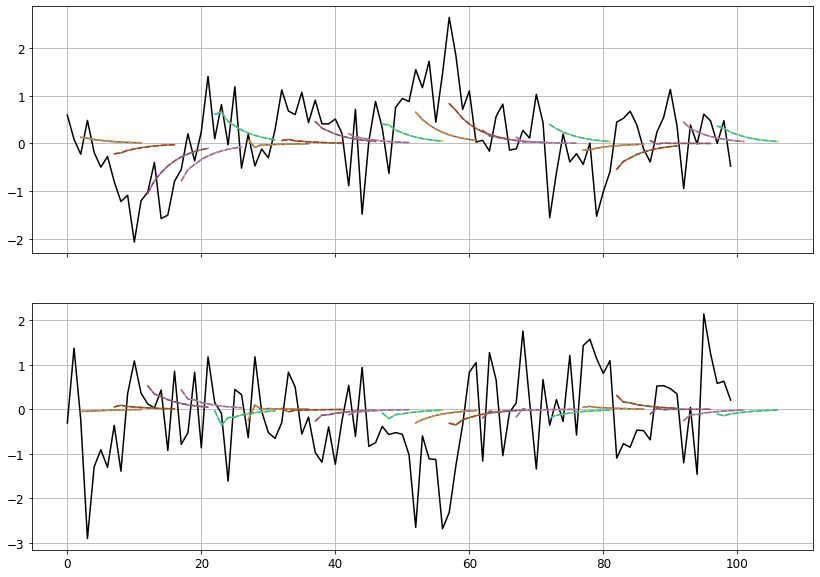

In [216]:
fig = plt.figure(figsize=(14, 10))
axs = fig.subplots(2, 1, sharex=True)

axs[0].plot(inits[:, sample, 0], color="k")
axs[1].plot(inits[:, sample, 1], color="k")

for init in range(1, len(inits), 5):
    my_forecast = my_forecasts.sel(init=init)

    lead = my_forecast.lead + init
    axs[0].plot(lead, my_forecast["var0"])
    axs[1].plot(lead, my_forecast["var1"])

    their_forecast = res.forecast(inits[: (init + 1), sample, :], n_steps)
    axs[0].plot(lead, their_forecast[:, 0], linestyle="--")
    axs[1].plot(lead, their_forecast[:, 1], linestyle="--")

axs[0].grid()
axs[1].grid()

### What do the 8-year means look like?

In [217]:
n_times = 50
n_samples = 1

inits = []
for _ in range(n_samples):
    inits.append(res.simulate_var(steps=n_times + order)[order:, ...])
inits = np.stack(inits, axis=1)

In [218]:
hcst = predict(
    res.params.to_numpy(),
    res.resid.std().to_numpy(),
    inits,
    n_steps=9,
    n_members=169,
).squeeze()

In [222]:
hcst_mean = hcst.sel(lead=slice(2, 9)).mean("lead")

Text(0.5, 1.0, 'AMV')

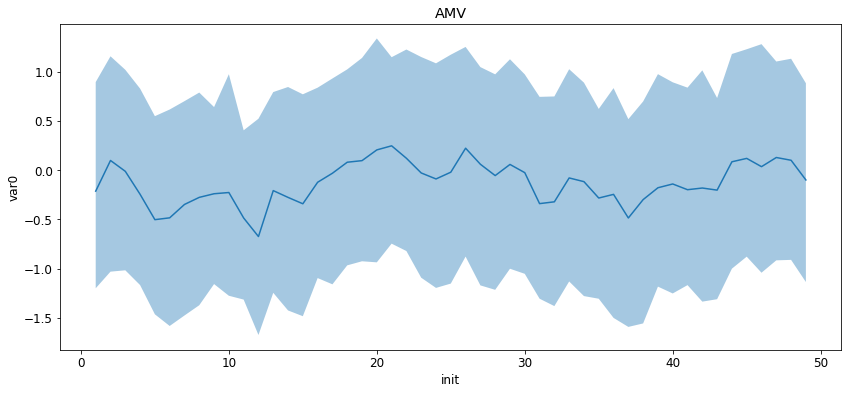

In [226]:
to_plot = hcst_mean["var0"]

plt.fill_between(
    to_plot.init,
    to_plot.quantile(0.05, dim="member"),
    to_plot.quantile(0.95, dim="member"),
    alpha=0.4,
)
to_plot.mean("member").plot()
plt.title("AMV")

Text(0.5, 1.0, 'NAO')

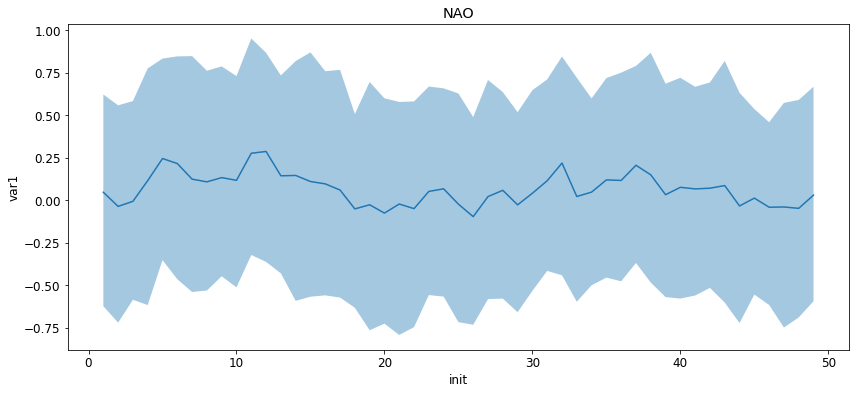

In [227]:
to_plot = hcst_mean["var1"]

plt.fill_between(
    to_plot.init,
    to_plot.quantile(0.05, dim="member"),
    to_plot.quantile(0.95, dim="member"),
    alpha=0.4,
)
to_plot.mean("member").plot()
plt.title("NAO")

### As a check, do the fit myself

In [361]:
order = 2

In [362]:
input_data = pd.concat(
    (AMV.sel(rolling_mean=1, drop=True).to_dataframe(),
    NAO.sel(rolling_mean=1, drop=True).to_dataframe()),
    axis=1
)

In [363]:
def OLS_fit(predictor, response):
    XtX = np.matmul(predictor.T, predictor)
    XtY = np.matmul(predictor.T, response)
    XtX_Inv = np.linalg.inv(XtX)
    
    b = np.matmul(XtX_Inv, XtY)
    
    return b

In [368]:
# Lag order with this approach is [y1_lag2, y1_lag1, y2_lag2, y2_lag1]
predictor = sliding_window_view(input_data.to_numpy(), window_shape=order, axis=0)
predictor = predictor.reshape((predictor.shape[0], -1))[:-1,:]

response = input_data.to_numpy()[order:]

my_params = pd.DataFrame(
    OLS_fit(predictor, response), 
    index = ["L2.AMV", "L1.AMV", "L2.NAO", "L1.NAO"], 
    columns = ['AMV','NAO']
)
my_params

,AMV,NAO
L2.AMV,0.258294,-9.742450
L1.AMV,0.435933,-1.676509
L2.NAO,0.000539,-0.012159
L1.NAO,-0.000936,0.062240


In [369]:
their_params = VAR(input_data).fit(order, trend="n").params
their_params

/g/data/xv83/users/ds0092/software/miniconda3/envs/squire_2022_correlation/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


,AMV,NAO
L1.AMV,0.435933,-1.676509
L1.NAO,-0.000936,0.062240
L2.AMV,0.258294,-9.742450
L2.NAO,0.000539,-0.012159


## Check that `res.sigma2` returned by `statsmodels` is just the variance of the residuals

In [371]:
from statsmodels.tsa.ar_model import AutoReg

res = AutoReg(input_data.to_numpy()[:,0], lags=2,trend="n").fit()

print(f"Square root of res.sigma2: {np.sqrt(res.sigma2)}")
print(f"Standard deviation of residuals: {np.std(res.resid)}")

Square root of res.sigma2: 0.10972550897069776
Standard deviation of residuals: 0.10972513235786074


## Extending `ar_model` to VAR models - checks

In [274]:
from src import ar_model

from statsmodels.tsa.api import VAR

from statsmodels.tsa.ar_model import AutoReg, ar_select_order

### Check that generate_samples matches `statsmodels.tsa.vector_ar.var_model import VARProcess`
Note, `generate_samples` below was run with `simulate_var(..., seed=0)` hardcoded internally

In [11]:
AMV_input = AMV.to_dataset().sel(rolling_mean=1, drop=True)
NAO_input = NAO.to_dataset().sel(rolling_mean=1, drop=True)

VAR_input = xr.merge((AMV_input, NAO_input))

In [13]:
order = 2
n_times = 50

res = VAR(VAR_input.to_dataframe()).fit(order, trend="n")

/g/data/xv83/users/ds0092/software/miniconda3/envs/squire_2022_correlation/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


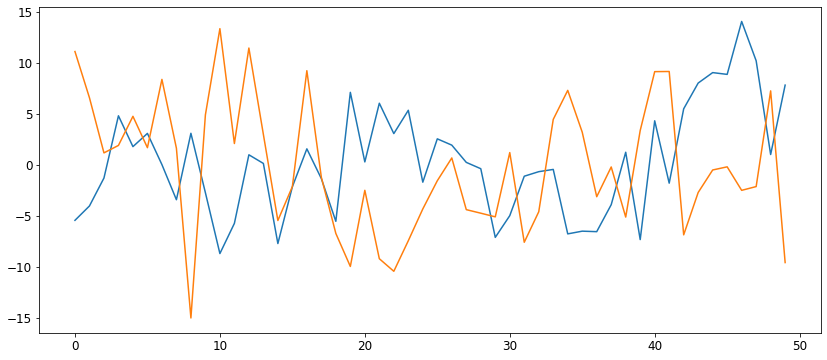

In [14]:
a = res.simulate_var(n_times + order, seed=0)[order:]

plt.plot(40 * a[:, 0])
plt.plot(a[:, 1])

In [17]:
VAR_params = ar_model.fit(VAR_input, n_lags=order)

b = ar_model.generate_samples(VAR_params, n_times=n_times, n_samples=1)

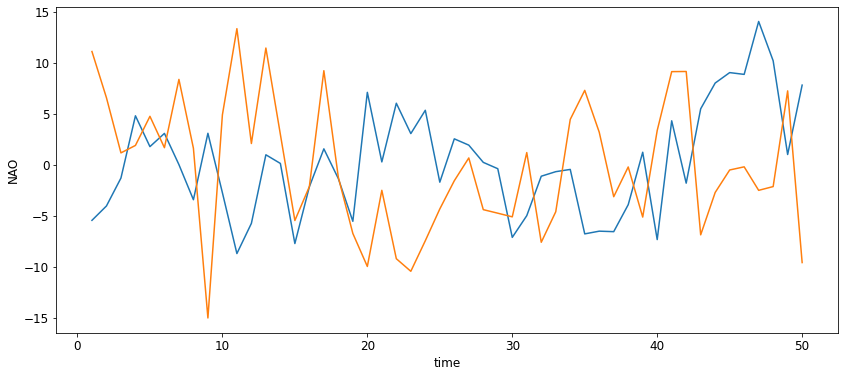

In [18]:
(40 * b["AMV"]).plot()
b["NAO"].plot()

### Check that predictions match `statsmodels` method

In [372]:
order = 4

In [373]:
VAR_params = ar_model.fit(VAR_input, n_lags=order)

inits = ar_model.generate_samples(VAR_params, n_times=100, n_samples=1)

In [374]:
VAR_params = xr.concat(
    (
        VAR_params.isel(params=slice(-2)),
        VAR_params - VAR_params.isel(params=slice(-2, None)),
    ),
    dim="params",
)

In [375]:
n_steps = 10
my_forecasts = ar_model.predict(VAR_params, inits, n_steps=n_steps).squeeze()

In [376]:
res = VAR(VAR_input.to_stacked_array(new_dim="var", sample_dims=["time"]).values).fit(
    order, trend="n"
)

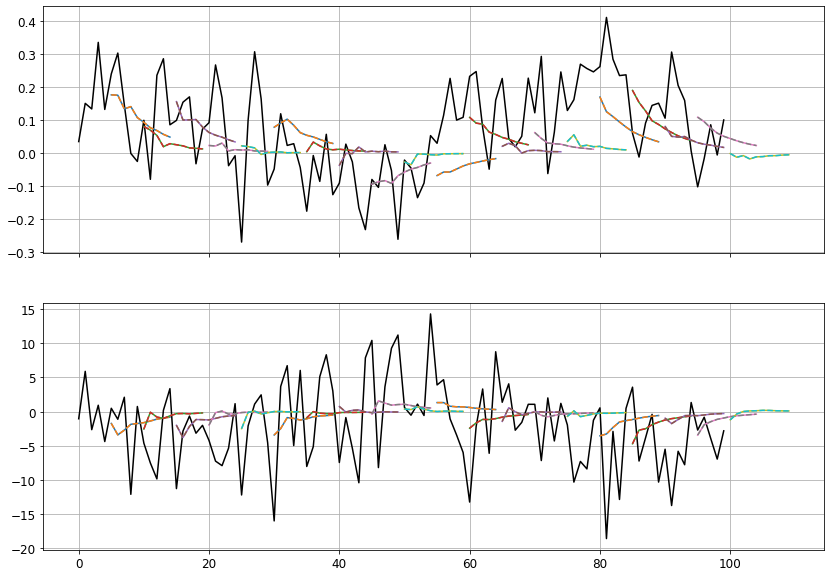

In [377]:
fig = plt.figure(figsize=(14, 10))
axs = fig.subplots(2, 1, sharex=True)

axs[0].plot(inits["AMV"], color="k")
axs[1].plot(inits["NAO"], color="k")

for init in my_forecasts.init.values[::5]:
    my_forecast = my_forecasts.sel(init=init)

    lead = my_forecast.lead + init
    axs[0].plot(lead, my_forecast["AMV"])
    axs[1].plot(lead, my_forecast["NAO"])

    their_forecast = res.forecast(
        inits.to_stacked_array(new_dim="var", sample_dims=["time"]).values[:init],
        n_steps,
    )
    axs[0].plot(lead, their_forecast[:, 0], linestyle="--")
    axs[1].plot(lead, their_forecast[:, 1], linestyle="--")

axs[0].grid()
axs[1].grid()

In [379]:
order = 2

In [380]:
AR_params = ar_model.fit(AMV_input, n_lags=order)

inits = ar_model.generate_samples(AR_params, n_times=100, n_samples=1)

# Refit to inits so that can use AutoReg predict function
AR_params = ar_model.fit(inits, n_lags=order)

In [381]:
AR_params = xr.concat(
    (
        AR_params.isel(params=slice(-1)),
        AR_params - AR_params.isel(params=slice(-1, None)),
    ),
    dim="params",
)

In [382]:
n_steps = 10

my_forecasts = ar_model.predict(AR_params, inits, n_steps=n_steps).squeeze()

In [383]:
res = AutoReg(inits["AMV"].values, lags=order, trend="n").fit()

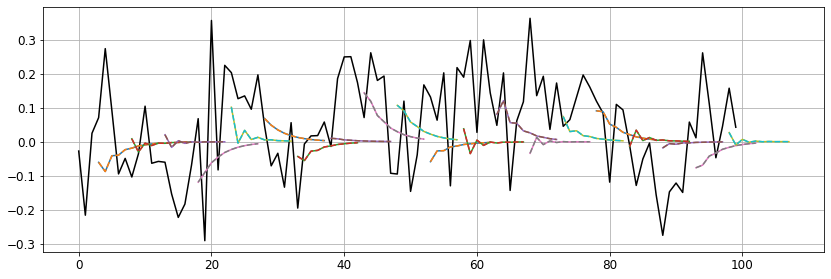

In [384]:
fig = plt.figure(figsize=(14, 4.5))
ax = fig.subplots(1, 1)

ax.plot(inits["AMV"], color="k")

for init in my_forecasts.init.values[::5]:
    my_forecast = my_forecasts.sel(init=init)

    lead = my_forecast.lead + init
    ax.plot(lead, my_forecast["AMV"])

    their_forecast = res.predict(init, init + n_steps - 1, dynamic=True)
    ax.plot(lead, their_forecast, linestyle="--")

ax.grid()

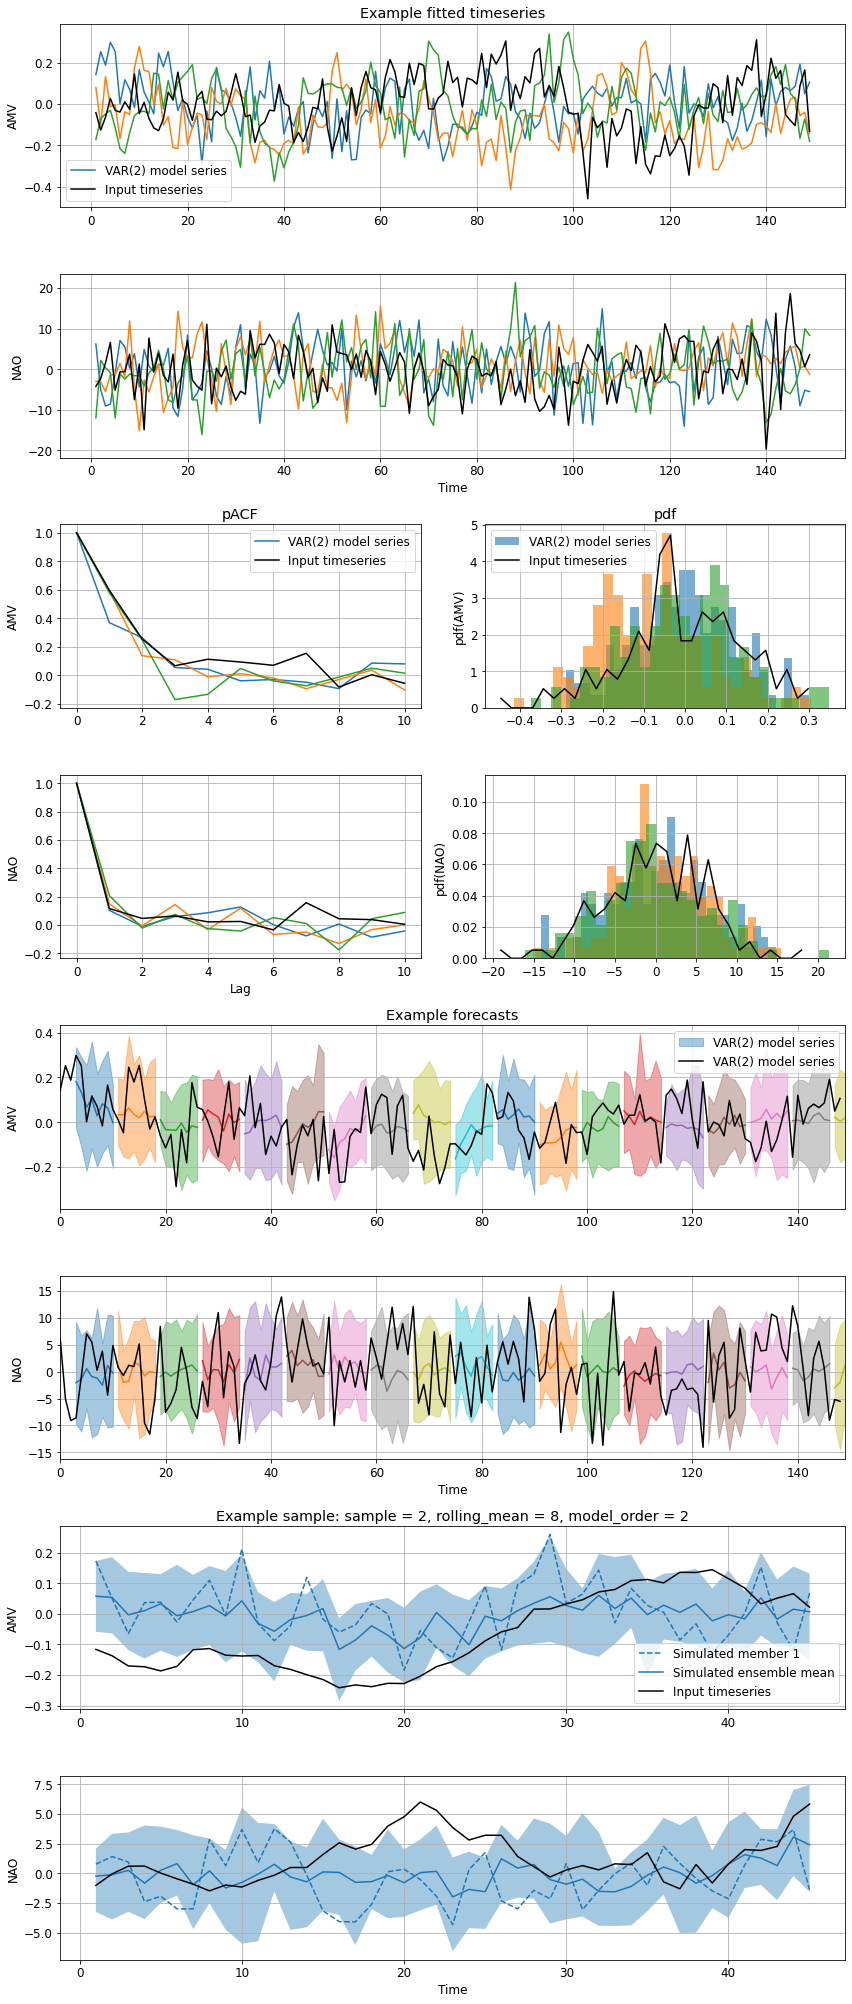

In [513]:
test = ar_model.generate_samples_like(
    VAR_input,
    n_lags=2,
    n_times=45,
    n_samples=3,
    n_members=20,
    rolling_means=[8],
    plot_diagnostics=True,
)

In [515]:
test

<xarray.Dataset>
Dimensions:       (sample: 3, rolling_mean: 2, time: 45, member: 20)
Coordinates:
  * sample        (sample) int64 0 1 2
  * member        (member) int64 0 1 2 3 4 5 6 7 8 ... 12 13 14 15 16 17 18 19
  * time          (time) int64 1 2 3 4 5 6 7 8 9 ... 37 38 39 40 41 42 43 44 45
  * rolling_mean  (rolling_mean) int64 1 8
    model_order   int64 2
Data variables:
    AMV           (rolling_mean, sample, time, member) float32 -0.127 ... -0....
    NAO           (rolling_mean, sample, time, member) float32 12.38 ... -0.9316